CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
from common_utils import split_dataset, preprocess_dataset
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
df_train, y_train, df_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, 42)
X_train, X_test = preprocess_dataset(df_train, df_test)
X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()
y_train, y_test = torch.tensor(y_train).float(), torch.tensor(y_test).float()

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
# TODO: Enter your code here
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features 
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset_train = AudioDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)

2. Next, define the model, optimizer and loss function.

In [5]:
model = MLP(57)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
from common_utils import EarlyStopper

train_accuracies, train_losses = [], []
test_accuracies, test_losses = [], []
early_stopper = EarlyStopper()
for epoch in range(100):
    #training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for features_batch, label_batch in dataloader_train:
        out = model(features_batch)
        loss = loss_fn(out, label_batch.view(-1, 1))
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct += ((out > 0.5) == label_batch.view(-1, 1)).sum().item()
        train_total += label_batch.size(0)

    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(dataloader_train)

    #validation
    model.eval()
    out = model(X_test)
    test_loss = loss_fn(out, y_test.view(-1, 1)).item()
    test_correct = ((out > 0.5) == y_test.view(-1, 1)).sum().item()
    test_total = y_test.size(0)
    test_accuracy = test_correct / test_total

    train_accuracies.append(train_accuracy), test_accuracies.append(test_accuracy)
    train_losses.append(train_loss), test_losses.append(test_loss)

    if early_stopper.early_stop(test_loss):
        break  

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

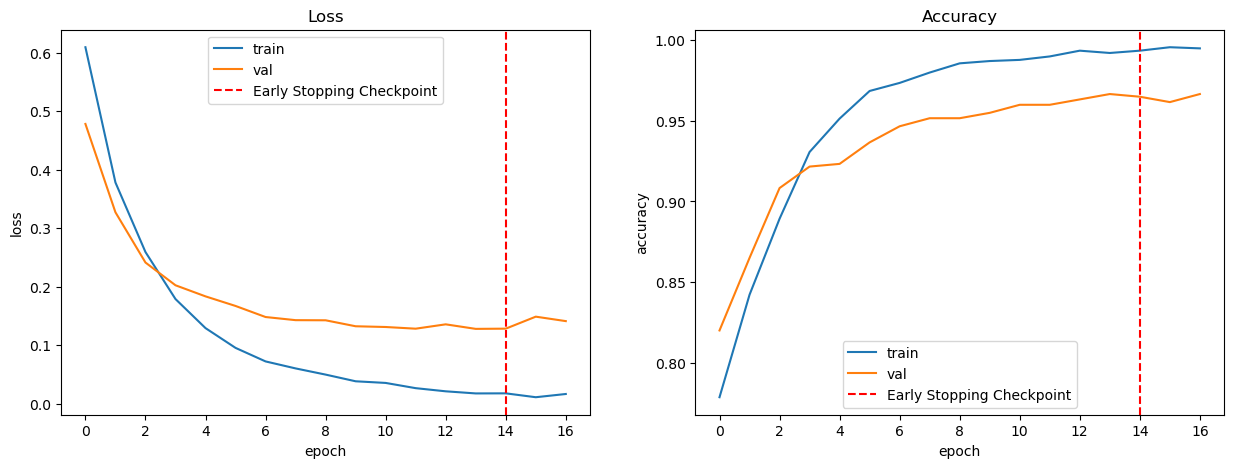

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='val')
minposs = test_losses.index(min(test_losses))+1 
ax[0].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax[0].set_title('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(train_accuracies, label='train')
ax[1].plot(test_accuracies, label='val')
ax[1].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend();

Both training and validation loss decreased initially. The training and validation loss start to diverge at about epoch 3. At epoch 14, the validation loss started increasing, suggesting that the model is beginning to overfit. <br>
Both training and validation accuracy increased initially. The training and validation accuracy start to diverge at about epoch 5. At epoch 13, the model reach the maximum accuracy before falling.

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [8]:
from common_utils import MLP

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [9]:
from common_utils import split_dataset, preprocess_dataset
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].apply(lambda x: x.split('.')[0]).to_numpy()
df.drop(columns=['filename'], inplace=True)
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [10]:
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {}, {}, {}, {}

kf = KFold(n_splits=5, shuffle=True) # Use randomly generate with notebook seed

for batch_size in [32, 64, 128, 256]:
    for train_index, test_index in kf.split(df):
        train_fold = df.iloc[train_index]
        test_fold = df.iloc[test_index]
        
        df_train, y_train = train_fold.drop(columns=['label']), train_fold['label'].to_numpy()
        df_test, y_test = test_fold.drop(columns=['label']), test_fold['label'].to_numpy()
        df_train, df_test = preprocess_dataset(df_train, df_test)
        df_train, df_test = torch.tensor(df_train).float(), torch.tensor(df_test).float()
        y_train, y_test = torch.tensor(y_train).float(), torch.tensor(y_test).float()
        
        X_train_scaled_dict[batch_size] = X_train_scaled_dict.get(batch_size, []) + [df_train]
        X_val_scaled_dict[batch_size] = X_val_scaled_dict.get(batch_size, []) + [df_test]
        y_train_dict[batch_size] = y_train_dict.get(batch_size, []) + [y_train]
        y_val_dict[batch_size] = y_val_dict.get(batch_size, []) + [y_test]


2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [11]:
accuracies, time_taken = {}, {}
for batch_size in [32, 64, 128, 256]:
    accuracies[batch_size] = []
    time_taken[batch_size] = []
    for fold in range(5): # 5-fold cross validation
        dataset_train = AudioDataset(X_train_scaled_dict[batch_size][fold], y_train_dict[batch_size][fold])
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        early_stopper = EarlyStopper()
        model = MLP(X_train_scaled_dict[batch_size][fold].shape[1])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()

        for epoch in range(100):
            #training
            model.train()
            start_time = time.time()
            for features_batch, label_batch in dataloader_train:
                out = model(features_batch)
                loss = loss_fn(out, label_batch.view(-1, 1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            end_time = time.time()

            #validation
            model.eval()
            out = model(X_val_scaled_dict[batch_size][fold])
            test_loss = loss_fn(out, y_val_dict[batch_size][fold].view(-1, 1)).item()
            test_correct = ((out > 0.5) == y_val_dict[batch_size][fold].view(-1, 1)).sum().item()
            test_total = y_val_dict[batch_size][fold].size(0)
            test_accuracy = test_correct / test_total

            if early_stopper.early_stop(test_loss):
                break

        accuracies[batch_size].append(test_accuracy)
        time_taken[batch_size].append(end_time - start_time)

        

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

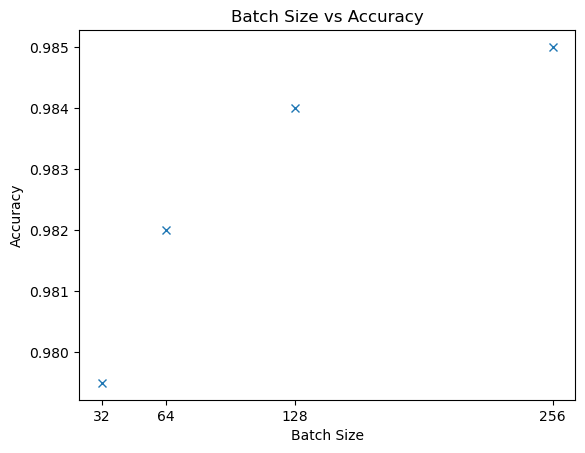

In [12]:
x = [32, 64, 128, 256]
y = [np.mean(accuracies[32]), np.mean(accuracies[64]), np.mean(accuracies[128]), np.mean(accuracies[256])]
plt.plot(x, y, marker='x', linestyle="none")
plt.xticks(x)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Batch Size vs Accuracy');

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [13]:
batch_times = []
for batch_size in [32, 64, 128, 256]:
    batch_times.append([batch_size, np.mean(time_taken[batch_size])])
df = pd.DataFrame(batch_times, columns=['Batch', 'Time Taken (s)'])
df

,Batch,Time Taken (s)
0,32,0.291395
1,64,0.175939
2,128,0.061592
3,256,0.037926


5. Select the optimal batch size and state a reason for your selection.

The optimal batch size is 256 as it resulted in the best accuracy and the lowest amount of time taken

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [14]:
from common_utils import MLP

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [15]:
accuracies = {}
batch_size = 256
for neurons in [64, 128, 256]:
    accuracies[neurons] = []
    for fold in range(5):
        dataset_train = AudioDataset(X_train_scaled_dict[batch_size][fold], y_train_dict[batch_size][fold]) #reuse the dataset
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        early_stopper = EarlyStopper()
        model = MLP(X_train_scaled_dict[batch_size][fold].shape[1], neurons)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()
        for epoch in range(100):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for features_batch, label_batch in dataloader_train:
                optimizer.zero_grad()
                out = model(features_batch)
                loss = loss_fn(out, label_batch.view(-1, 1))
                train_loss += loss.item()
                loss.backward()
                optimizer.step()
                train_correct += ((out > 0.5) == label_batch.view(-1, 1)).sum().item()
                train_total += label_batch.size(0)
            train_accuracy = train_correct / train_total
            train_loss = train_loss / len(dataloader_train)
            model.eval()
            out = model(X_val_scaled_dict[batch_size][fold])
            test_loss = loss_fn(out, y_val_dict[batch_size][fold].view(-1, 1)).item()
            test_correct = ((out > 0.5) == y_val_dict[batch_size][fold].view(-1, 1)).sum().item()
            test_total = y_val_dict[batch_size][fold].size(0)
            test_accuracy = test_correct / test_total
            
            if early_stopper.early_stop(test_loss):
                break
        accuracies[neurons].append(test_accuracy)
        

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

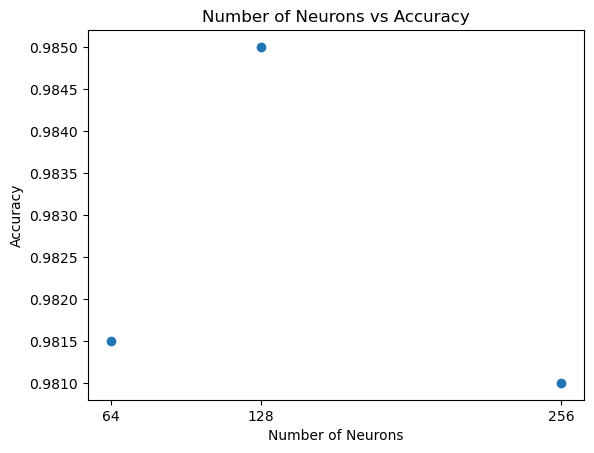

In [16]:
x = [64, 128, 256]
y = [np.mean(accuracies[64]), np.mean(accuracies[128]), np.mean(accuracies[256])]
plt.scatter(x, y)
plt.xticks(x)
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.title('Number of Neurons vs Accuracy');

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [17]:
model = MLP(57, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

The optimal number of neuron is 128 as it is able to achieve the highest mean accuracy

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

In [18]:
from common_utils import split_dataset, preprocess_dataset
# reprocess dataset same as Q1
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].apply(lambda x: x.split('.')[0])
df_train, y_train, df_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, 42)
X_train, X_test = preprocess_dataset(df_train, df_test)
X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()
y_train, y_test = torch.tensor(y_train).float(), torch.tensor(y_test).float()

dataset_train = AudioDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)

train_accuracies, train_losses = [], []
test_accuracies, test_losses = [], []
early_stopper = EarlyStopper()
for epoch in range(100):
    #training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for features_batch, label_batch in dataloader_train:
        out = model(features_batch)
        loss = loss_fn(out, label_batch.view(-1, 1))
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct += ((out > 0.5) == label_batch.view(-1, 1)).sum().item()
        train_total += label_batch.size(0)
    train_accuracy = train_correct / train_total
    train_loss = train_loss / len(dataloader_train)
    
    #validation
    model.eval()
    out = model(X_test)
    test_loss = loss_fn(out, y_test.view(-1, 1)).item()
    test_correct = ((out > 0.5) == y_test.view(-1, 1)).sum().item()
    test_total = y_test.size(0)
    test_accuracy = test_correct / test_total
    train_accuracies.append(train_accuracy), test_accuracies.append(test_accuracy)
    train_losses.append(train_loss), test_losses.append(test_loss)
    
    if early_stopper.early_stop(test_loss):
        break
        

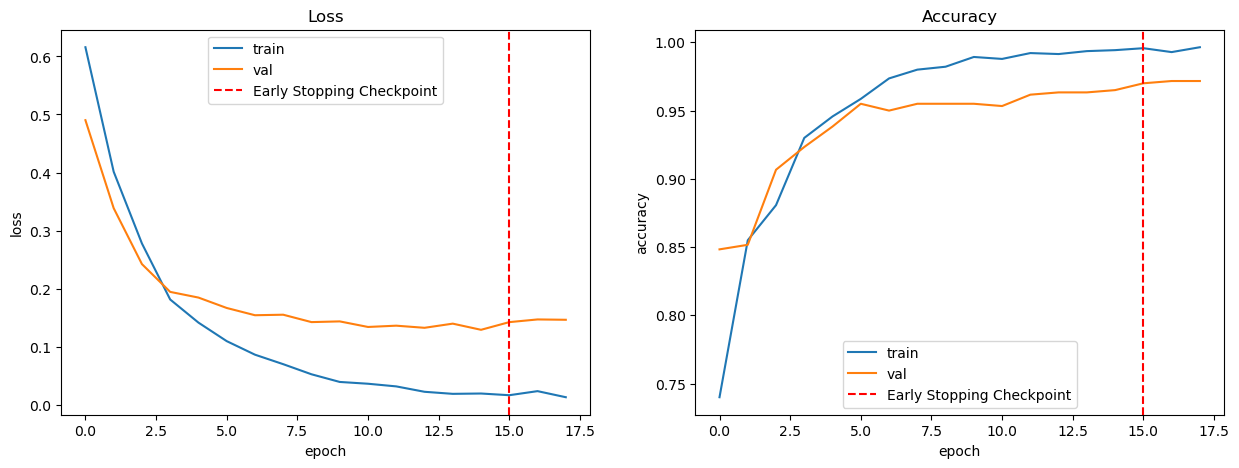

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='val')
minposs = test_losses.index(min(test_losses))+1 
ax[0].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax[0].set_title('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(train_accuracies, label='train')
ax[1].plot(test_accuracies, label='val')
ax[1].axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend();

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [20]:
# TODO: Enter your code here
from common_utils import MLP

> Install and import shap

In [21]:
# TODO: Enter your code here
import shap

c:\Users\JJWX\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [22]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [23]:
from common_utils import extract_features
df = extract_features('audio_test.wav')
size_row = df.shape[0]
size_column = df.shape[1]

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [24]:
df.drop(columns=['filename'], inplace=True)
X_train, X_test = preprocess_dataset(df_train, df)
with torch.no_grad():
    X_train, X_test = torch.tensor(X_train).float(), torch.tensor(X_test).float()

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [25]:
with torch.no_grad():
    out = model(X_test) # Same model from Q3
pred_label = "Metal" if (out > 0.5).item() else "Blues"
print(pred_label)

Blues


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [28]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)
shap_values_reshaped = np.reshape(shap_values, (1, 57))

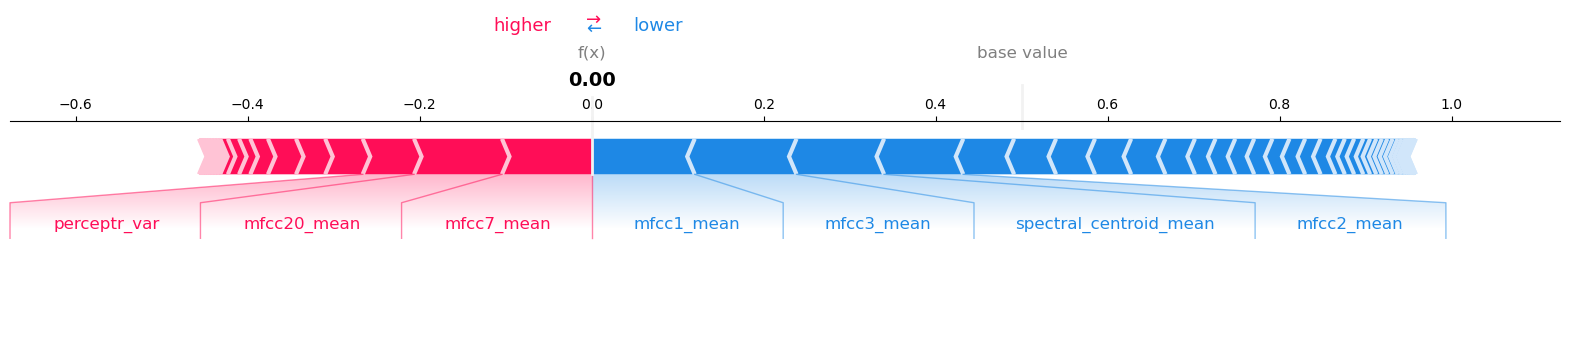

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_reshaped[0], feature_names=df.columns, matplotlib=True)

The plot suggest that perceptr_var, mfcc20_mean, mfcc7_mean are two greatest contributor of increasing the likelihood of predicting metal and mfcc2_mean mfcc1_mean, mfcc3_mean and spectral_centroid_meanare the main contributors of increasing the likelihood of predicting blues.